In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from retinanet import coco_eval
from retinanet import csv_eval
from retinanet import model
from retinanet import paps_eval
from retinanet import paps_train
from retinanet.nms import get_nmsbox

# from retinanet import retina
from retinanet.dataloader import *
from retinanet.anchors import Anchors
from retinanet.losses import *
from retinanet.scheduler import *
from retinanet.hourglass import hg1, hg2, hg8
from retinanet.parallel import DataParallelModel, DataParallelCriterion

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam, lr_scheduler
import torch.optim as optim


In [2]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(img, bbox, cla, color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
    if int(cla) == 1 :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    else :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255,255,0), thickness=thickness)
    return img

def visualize(image, bboxes, classes):
    img = image.copy()
#     img = image.clone().detach()
    for bbox, cla in zip(bboxes, classes):
#         print(bbox)
        img = visualize_bbox(img, bbox, cla)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [3]:
device = torch.device('cpu')
# device = torch.device('cuda')
GPU_NUM = 6 # 원하는 GPU 번호 입력
# device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
model = hg2(device, pretrained=True, progress=False, num_classes=2)
# model.to(device)

num_classes 2


In [4]:
# saved_dir = '../trained_models/HourGlass/loss_filter1/'
saved_dir = '../trained_models/HourGlass/loss_filter' + str(GPU_NUM) + '/'
e_epoch=120
if os.path.isfile(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt') :
    print('pretrainind file loading')
    state = torch.load(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt')
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'], strict=False)
#     optimizer.load_state_dict(state['optimizer'])
    last_loss = state['loss']
else :
    last_loss = 0.6

pretrainind file loading


In [5]:
dataset_val = PapsDataset('../data/', set_name='val_2class',
                            transform=val_transforms)

val_data_loader = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [80]:
model.training = False

for index, data in enumerate(tqdm(val_data_loader)) :
    with torch.no_grad():        
        images, tbox, tlabel, targets = data
#         print(images[0].shape)
#         print('targets', targets)
        batch_size = len(images)

        c, h, w = images[0].shape
        images = torch.cat(images).view(-1, c, h, w).to(device)

        outputs = model(images)
        scores, labels, boxes = (outputs)
#         print('scores', scores)
#         print(labels)
#         print(boxes)

        scores = scores.cpu()
        labels = labels.cpu()
        boxes  = boxes.cpu()  

#         scores_list.append(scores)

        if boxes.shape[0] > 0:
            # change to (x, y, w, h) (MS COCO standard)
            boxes[:, 2] -= boxes[:, 0]
            boxes[:, 3] -= boxes[:, 1]
    if int(targets[0][0,4]) == 1 :
        print(targets)
        break

  1%|▏         | 56/3739 [00:12<14:14,  4.31it/s]

(tensor([[165.5000,  36.7500, 177.0000,  51.7500,   1.0000],
        [184.0000,  54.5000, 199.7500,  73.7500,   1.0000],
        [106.0000, 111.7500, 118.7500, 124.5000,   1.0000],
        [246.5000, 187.5000, 265.0000, 201.0000,   1.0000],
        [ 91.2500, 192.0000, 106.2500, 206.2500,   1.0000],
        [139.2500, 207.5000, 156.2500, 219.5000,   1.0000],
        [ 92.7500,   1.5000, 105.5000,  12.7500,   1.0000],
        [278.0000,  78.0000, 289.5000,  88.5000,   1.0000],
        [237.7500, 253.0000, 253.2500, 268.0000,   1.0000],
        [185.5000, 203.0000, 199.0000, 217.2500,   1.0000],
        [215.5000, 277.2500, 230.5000, 295.2500,   1.0000],
        [ 78.7500, 300.7500,  93.7500, 318.0000,   1.0000]]),)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([320, 320, 3])


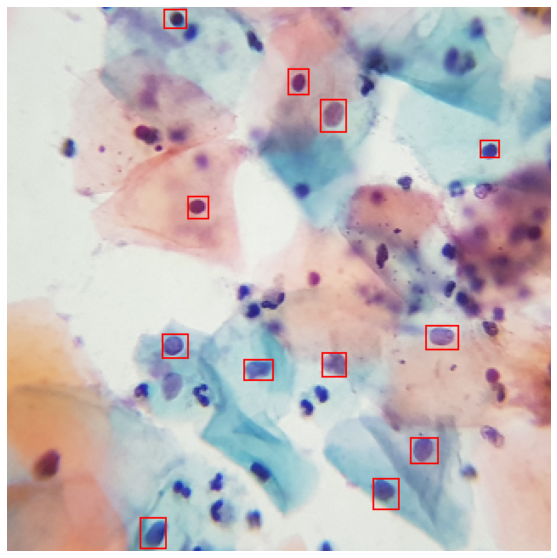

In [81]:
image = images.squeeze()
image = torch.transpose(image, 0, 1)
image = torch.transpose(image, 1, 2)
print(image.shape)
visualize(image.numpy(), targets[0][:,:4], targets[0][:,4])

In [82]:

nboxes, nscores = get_nmsbox(boxes, scores, isCenter=True, iou_threshold=0.3)
# print((boxes))
for b in nboxes :
    b[2] += b[0]
    b[3] += b[1]
# boxes

tensor([])
[]


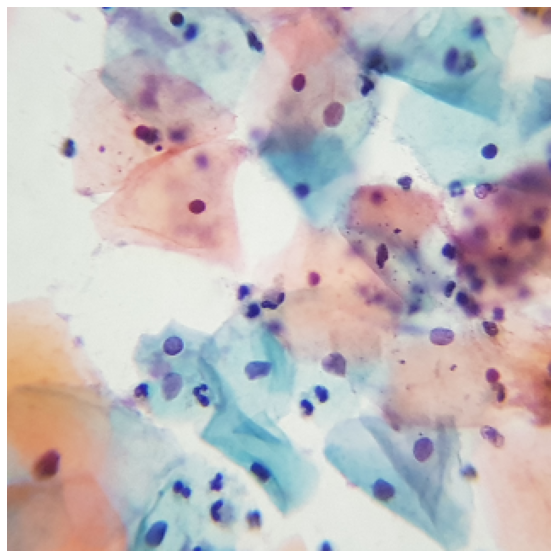

In [83]:
pred_box = []
for s,b in zip(nscores, nboxes) :
    if s > 0.05 :
        pred_box.append(b)
print(scores) 
print(pred_box)
visualize(image.numpy(), pred_box, labels)

In [39]:
saved_dir + 'val_2class_GTbbox_results.json'

'../trained_models/HourGlass/loss_filter6/val_2class_GTbbox_results.json'

In [19]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# annType = 'bbox'

# cocoGt=COCO(saved_dir + 'val_2class_GTbbox_results.json')
# cocoDt=cocoGt.loadRes(saved_dir + 'val_2class_bbox_results.json')
coco_true = dataset_val.coco
coco_pred = coco_true.loadRes(saved_dir + '{}_bbox_results.json'.format(dataset_val.set_name))
coco_gt = coco_true.loadRes(saved_dir + '{}_GTbbox_results.json'.format(dataset_val.set_name))


# running evaluation
cocoEval = COCOeval(coco_gt,coco_pred,'bbox')
cocoEval.params.imgIds = 1
cocoEval.params.iouThrs = [.1]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.69s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.10:0.10 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | m

In [52]:
cocoEval.params.iouThrs

<bound method Params.setDetParams of <pycocotools.cocoeval.Params object at 0x7f70e72cd6d0>>